In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

## File Loading

In [2]:
#File di info su PoI
poi_info_csv = "C:\\Users\\alfon\\Documents\\Master\\Progettone\\data_preparation\\reviews_csv\\output\\poi_info.csv"
df_poi = pd.read_csv(poi_info_csv, delimiter=',', encoding='utf-8', skipinitialspace=True)

#File delle recensioni
reviews_3_distinct_poi = "C:\\Users\\alfon\\Documents\\Master\\Progettone\\data_preparation\\reviews_csv\\output\\reviews_3_distinct_poi.csv"
df_reviews = pd.read_csv(reviews_3_distinct_poi, delimiter=',', quotechar='|', encoding='utf-8', skipinitialspace=True)

#Mappping dei Rating
rating_dict={1: -2,
             2: -1,
             3: 0,
             4: 1,
             5: 2
}
df_reviews['rating'] = df_reviews['rating'].map(rating_dict)

#File delle liste invertite user-category (conteggio delle recesioni di PoI distinti in ciascuna categoria per utente)
inv_user_category_count_csv = "C:\\Users\\alfon\\Documents\\Master\\Progettone\\data_preparation\\reviews_csv\\output\\inv_user_category_count.csv"
df_inv_cat = pd.read_csv(inv_user_category_count_csv, delimiter=',', quotechar='"', encoding='utf-8', skipinitialspace=True)
df_inv_cat = df_inv_cat.set_index('user')

cat_columns = df_inv_cat.columns

## Define Tourist Interest for each Category

In [4]:
tourist1 = np.array([5,3,5,1,3,1,3,1,2])
tourist2 = np.array([1,2,1,3,3,4,2,5,5])
tourist3 = np.array([3,2,1,2,2,5,5,3,3])
tourist = tourist1
df_tourist = pd.DataFrame(tourist, columns=['interest'])
df_tourist['category'] = cat_columns
df_tourist

,interest,category
0,5,Architecture
1,3,Art-Culture
2,5,Churches-Religious Sites
3,1,Entertainment
4,3,History
5,1,Monuments-Statue
6,3,Museums
7,1,Nature
8,2,Walking Areas


## Calculate mean rating weighted by similarity tourist-user

In [5]:
scaler = MinMaxScaler()

#df_user_sim
#dataframe contente per ogni utente la cosine similarity con il turista
df_user_sim = pd.DataFrame()
df_user_sim['user'] = df_inv_cat.index
df_user_sim['sim'] = cosine_similarity(df_tourist['interest'].values.reshape(1, -1), df_inv_cat)[0]

#df_sim_rating
#dataframe contente per ogni PoI:
#sim = la media della similarità degli degli utenti che hanno recensito il PoI
#rating = la media dei rating attribuiti dagli utenti che hanno recensito il PoI
#sim_rating = la media "pesata" del rating attribuiti dagli utenti, dove il peso è lo score di similarità dell'utente
df_sim_rating = df_reviews[['poi_id','user', 'rating']].copy()
df_sim_rating = df_sim_rating.merge(df_user_sim, on='user')
df_sim_rating['sim_rating'] = df_sim_rating['sim']*df_sim_rating['rating']
df_sim_rating = df_sim_rating.pivot_table(index='poi_id', values=['sim','rating', 'sim_rating'], aggfunc='mean' )
df_sim_rating = df_sim_rating.reset_index()
df_sim_rating = df_sim_rating.merge(df_poi[['poi_id', 'category_1']], on='poi_id')
df_sim_rating = df_sim_rating.merge(df_tourist, left_on='category_1', right_on='category').drop(['category', 'category_1'], axis=1)
df_sim_rating['interest'] = df_sim_rating['interest']/5

#df_poi_rank: merge di df_sim_rating con df_poi
df_poi_rank = df_poi[['poi_id', 'name', 'zone', 'actual_n_reviews', 'duration_num',
                      'lat', 'long', 'category_1', 'category_2']].merge(
                    df_sim_rating, on='poi_id').sort_values(by='sim_rating', ascending=False)
df_poi_rank['popularity'] = scaler.fit_transform(np.log2(df_poi_rank['actual_n_reviews']).values.reshape(-1, 1))

In [6]:
#Metodo 1
#Rank dato dalla media pesate dei rating e similarità con l'aggiunta di popolarità
rat1 = 1
pop1 = 0.2
df_poi_rank['rank_1'] = rat1*df_poi_rank['sim_rating'] + pop1*df_poi_rank['popularity']

In [11]:
#Metodo 2
#Rank dato da una combinazione lineare delle 4 variabili: rating, similarità, interesse e popolarità
rat2 = 1
sim = 1
inte = 0.3
pop2 = 0.2
df_poi_rank['rank_2'] = rat2*df_poi_rank['rating'] +sim*df_poi_rank['sim'] + inte*df_poi_rank['interest'] + pop2*df_poi_rank['popularity']

In [8]:
df_poi_rank_sel1 = df_poi_rank.sort_values(by='rank_1', ascending=False).iloc[:50]
df_poi_rank_sel1

,poi_id,name,zone,actual_n_reviews,duration_num,lat,long,category_1,category_2,rating,sim,sim_rating,interest,popularity,rank_1
9,d591217,Chiesa di San Maurizio al Monastero Maggiore,Centro Storico,2229,0.75,45.465575,9.178940,Churches-Religious Sites,Art-Culture,1.848811,0.720639,1.332973,1.0,0.807515,1.494476
287,d7390600,Museo Di Sant'Eustorgio,Ticinese,23,2.50,45.454067,9.180958,Museums,Churches-Religious Sites,1.695652,0.807145,1.375180,0.6,0.328429,1.440866
4,d6124852,Duomo Rooftops,Centro Storico,3628,1.50,45.464098,9.191926,Architecture,History,1.731808,0.722412,1.253353,1.0,0.858539,1.425061
39,d13229415,Torre Hadid,Zone 8,41,0.25,45.477856,9.155203,Architecture,NaN,1.682927,0.771940,1.312524,1.0,0.388980,1.390320
291,d6686075,Fonderia Napoleonica Eugenia,Zone 9,18,2.50,45.493279,9.187848,Museums,History,1.666667,0.806420,1.325398,0.6,0.302753,1.385949
53,d1062832,Palazzo Clerici,Centro Storico,77,1.50,45.466772,9.187100,Architecture,Museums,1.558442,0.821446,1.284140,1.0,0.454994,1.375139
243,d1930515,Villa Necchi Campiglio,Centro Storico,1001,2.50,45.468323,9.201836,Architecture,Museums,1.669331,0.738066,1.230205,1.0,0.723661,1.374937
1,d314197,Il Cenacolo,Centro Storico,5066,1.50,45.466307,9.170647,Art-Culture,Museums,1.701737,0.694777,1.186238,0.6,0.893511,1.364940
202,d2160064,The Bramante Sacristy,Centro Storico,46,0.75,45.466240,9.171693,Churches-Religious Sites,Art-Culture,1.630435,0.785735,1.284277,1.0,0.401033,1.364483
71,d1905650,Palazzo Castiglioni,Centro Storico,47,0.25,45.471128,9.201379,Architecture,Museums,1.510638,0.847672,1.276698,1.0,0.403285,1.357355


In [13]:
df_poi_rank_sel2 = df_poi_rank.sort_values(by='rank_2', ascending=False).iloc[:50]
df_poi_rank_sel2

,poi_id,name,zone,actual_n_reviews,duration_num,lat,long,category_1,category_2,rating,sim,sim_rating,interest,popularity,rank_1,rank_2
9,d591217,Chiesa di San Maurizio al Monastero Maggiore,Centro Storico,2229,0.75,45.465575,9.178940,Churches-Religious Sites,Art-Culture,1.848811,0.720639,1.332973,1.0,0.807515,1.494476,3.030953
4,d6124852,Duomo Rooftops,Centro Storico,3628,1.50,45.464098,9.191926,Architecture,History,1.731808,0.722412,1.253353,1.0,0.858539,1.425061,2.925928
0,d195239,Duomo di Milano,Centro Storico,14002,2.50,45.464098,9.191926,Churches-Religious Sites,Architecture,1.737537,0.663049,1.153392,1.0,1.000000,1.353392,2.900587
243,d1930515,Villa Necchi Campiglio,Centro Storico,1001,2.50,45.468323,9.201836,Architecture,Museums,1.669331,0.738066,1.230205,1.0,0.723661,1.374937,2.852129
16,d246678,Chiesa di Santa Maria presso San Satiro,Centro Storico,1116,0.75,45.462778,9.187778,Churches-Religious Sites,Architecture,1.668459,0.723373,1.205235,1.0,0.735052,1.352245,2.838842
39,d13229415,Torre Hadid,Zone 8,41,0.25,45.477856,9.155203,Architecture,NaN,1.682927,0.771940,1.312524,1.0,0.388980,1.390320,2.832663
202,d2160064,The Bramante Sacristy,Centro Storico,46,0.75,45.466240,9.171693,Churches-Religious Sites,Art-Culture,1.630435,0.785735,1.284277,1.0,0.401033,1.364483,2.796376
14,d591187,Basilica di Sant'Ambrogio,Centro Storico,1889,2.50,45.462329,9.175612,Churches-Religious Sites,Architecture,1.619375,0.717770,1.165187,1.0,0.790179,1.323223,2.795181
53,d1062832,Palazzo Clerici,Centro Storico,77,1.50,45.466772,9.187100,Architecture,Museums,1.558442,0.821446,1.284140,1.0,0.454994,1.375139,2.770886
28,d591213,Certosa di Milano,Zone 8,213,1.50,45.502373,9.129558,Churches-Religious Sites,Art-Culture,1.596244,0.757058,1.207079,1.0,0.561571,1.319393,2.765617


In [9]:
df_poi_rank_sel1['category_1'].value_counts()

Architecture                16
Churches-Religious Sites    16
Museums                      9
Art-Culture                  4
History                      2
Monuments-Statue             1
Nature                       1
Walking Areas                1
Name: category_1, dtype: int64

In [14]:
df_poi_rank_sel2['category_1'].value_counts()

Churches-Religious Sites    20
Architecture                16
Museums                      8
Art-Culture                  3
History                      2
Monuments-Statue             1
Name: category_1, dtype: int64

In [10]:
df_tourist

,interest,category
0,5,Architecture
1,3,Art-Culture
2,5,Churches-Religious Sites
3,1,Entertainment
4,3,History
5,1,Monuments-Statue
6,3,Museums
7,1,Nature
8,2,Walking Areas


## Cluster on Map

In [15]:
from geopy import distance
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import folium
from folium.plugins import MarkerCluster

In [16]:
coord1 = df_poi_rank_sel1.set_index('poi_id')[['lat', 'long']]
coord2 = df_poi_rank_sel2.set_index('poi_id')[['lat', 'long']]

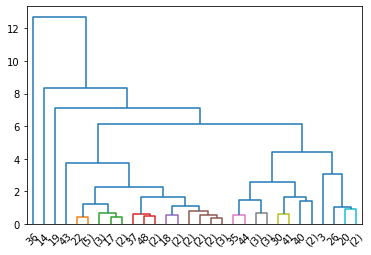

In [17]:
threshold = 1
data_link = linkage(coord1, method='complete', metric=lambda u,v: distance.distance(u,v).km)
labels = fcluster(data_link, t=threshold, criterion='distance')
df_poi_rank_sel1['label_hier'] = labels
res = dendrogram(data_link, color_threshold=threshold, truncate_mode='lastp')

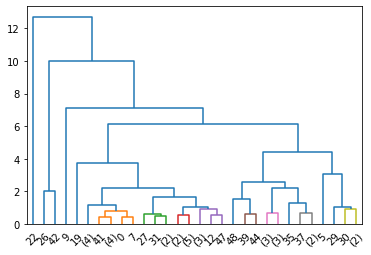

In [24]:
threshold = 1
data_link = linkage(coord2, method='complete', metric=lambda u,v: distance.distance(u,v).km)
labels = fcluster(data_link, t=threshold, criterion='distance')
df_poi_rank_sel2['label_hier'] = labels
res = dendrogram(data_link, color_threshold=threshold, truncate_mode='lastp')

In [20]:
map1 = folium.Map(location = [45.46, 9.18],zoom_start = 13, tiles='cartodbpositron', control_scale = True)  

colori = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

fg=folium.FeatureGroup(name="Poi Ratings")
for lat,lon,name,label in zip(df_poi_rank_sel1['lat'],df_poi_rank_sel1['long'],df_poi_rank_sel1['name'],df_poi_rank_sel1['label_hier']):
    fg.add_child(folium.Marker(location=[lat,lon],popup=(folium.Popup(name)),icon=folium.Icon(color=colori[label],icon_color='white')))
map1.add_child(fg)
map1

In [25]:
map2 = folium.Map(location = [45.46, 9.18],zoom_start = 13, tiles='cartodbpositron', control_scale = True)  

colori = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

fg=folium.FeatureGroup(name="Poi Ratings")
for lat,lon,name,label in zip(df_poi_rank_sel2['lat'],df_poi_rank_sel2['long'],df_poi_rank_sel2['name'],df_poi_rank_sel2['label_hier']):
    fg.add_child(folium.Marker(location=[lat,lon],popup=(folium.Popup(name)),icon=folium.Icon(color=colori[label],icon_color='white')))
map2.add_child(fg)
map2

IndexError: list index out of range

In [23]:
df_poi_rank_sel1

,poi_id,name,zone,actual_n_reviews,duration_num,lat,long,category_1,category_2,rating,sim,sim_rating,interest,popularity,rank_1,label_hier
9,d591217,Chiesa di San Maurizio al Monastero Maggiore,Centro Storico,2229,0.75,45.465575,9.178940,Churches-Religious Sites,Art-Culture,1.848811,0.720639,1.332973,1.0,0.807515,1.494476,2
287,d7390600,Museo Di Sant'Eustorgio,Ticinese,23,2.50,45.454067,9.180958,Museums,Churches-Religious Sites,1.695652,0.807145,1.375180,0.6,0.328429,1.440866,3
4,d6124852,Duomo Rooftops,Centro Storico,3628,1.50,45.464098,9.191926,Architecture,History,1.731808,0.722412,1.253353,1.0,0.858539,1.425061,5
39,d13229415,Torre Hadid,Zone 8,41,0.25,45.477856,9.155203,Architecture,NaN,1.682927,0.771940,1.312524,1.0,0.388980,1.390320,14
291,d6686075,Fonderia Napoleonica Eugenia,Zone 9,18,2.50,45.493279,9.187848,Museums,History,1.666667,0.806420,1.325398,0.6,0.302753,1.385949,12
53,d1062832,Palazzo Clerici,Centro Storico,77,1.50,45.466772,9.187100,Architecture,Museums,1.558442,0.821446,1.284140,1.0,0.454994,1.375139,5
243,d1930515,Villa Necchi Campiglio,Centro Storico,1001,2.50,45.468323,9.201836,Architecture,Museums,1.669331,0.738066,1.230205,1.0,0.723661,1.374937,8
1,d314197,Il Cenacolo,Centro Storico,5066,1.50,45.466307,9.170647,Art-Culture,Museums,1.701737,0.694777,1.186238,0.6,0.893511,1.364940,2
202,d2160064,The Bramante Sacristy,Centro Storico,46,0.75,45.466240,9.171693,Churches-Religious Sites,Art-Culture,1.630435,0.785735,1.284277,1.0,0.401033,1.364483,2
71,d1905650,Palazzo Castiglioni,Centro Storico,47,0.25,45.471128,9.201379,Architecture,Museums,1.510638,0.847672,1.276698,1.0,0.403285,1.357355,8


In [33]:
import folium
from folium.features import DivIcon

def number_DivIcon(color,number):
    #Create a 'numbered' icon
    icon = DivIcon(
            icon_size=(150,36),
            icon_anchor=(14,40),
            html="""<span class="fa-stack " style="font-size: 10pt" >
                    <!-- The icon that will wrap the number -->
                    <span class="fa fa-circle-o fa-stack-2x" style="color : {:s}"></span>
                    <!-- a strong element with the custom content, in this case a number -->
                    <strong class="fa-stack-1x">
                         {:s}  
                    </strong>
                </span>""".format(color,number)
        )
    return icon

col_hex = ['#440154',
 '#481a6c',
 '#472f7d',
 '#414487',
 '#39568c',
 '#31688e',
 '#2a788e',
 '#23888e',
 '#1f988b',
 '#22a884',
 '#35b779',
 '#54c568',
 '#7ad151',
 '#a5db36',
 '#d2e21b']

colori = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

In [195]:
map1 = folium.Map(location = [45.46, 9.18],zoom_start = 13, tiles='cartodbpositron', control_scale = True)  

for lat,lon,name,label,idx in zip(df_poi_rank_sel1['lat'],
                              df_poi_rank_sel1['long'],
                              df_poi_rank_sel1['name'],
                              df_poi_rank_sel1['label_hier'],
                              df_poi_rank_sel1.index):
    folium.Marker(
        location=[lat,lon],
        popup=(folium.Popup(name)),
        icon= number_DivIcon(colori[label],str(idx+1))
    ).add_to(map1)
map1


In [196]:
map2 = folium.Map(location = [45.46, 9.18],zoom_start = 13, tiles='cartodbpositron', control_scale = True)  

for lat,lon,name,label,idx in zip(df_poi_rank_sel2['lat'],
                              df_poi_rank_sel2['long'],
                              df_poi_rank_sel2['name'],
                              df_poi_rank_sel2['label_hier'],
                              df_poi_rank_sel2.index):
    folium.Marker(
        location=[lat,lon],
        popup=(folium.Popup(name)),
        icon= number_DivIcon(colori[label],str(idx+1))
    ).add_to(map2)
map2


In [178]:
map1 = folium.Map(location = [45.46, 9.18],zoom_start = 13, tiles='cartodbpositron', control_scale = True) 
locations = list(zip(df_poi_rank_sel1['lat'], df_poi_rank_sel1['long']))
icons = [number_DivIcon(colori[label],idx+1) for label, idx in zip(df_poi_rank_sel1['label_hier'],df_poi_rank_sel1.index)]
popup = df_poi_rank_sel1['name'].to_list()
marker_cluster = MarkerCluster(locations=locations, icons=icons, popups=popup, options={'maxClusterRadius':10} ).add_to(map1)
map1

ValueError: Unknown format code 's' for object of type 'int'

In [179]:
map2 = folium.Map(location = [45.46, 9.18],zoom_start = 13, tiles='cartodbpositron', control_scale = True) 
locations = list(zip(df_poi_rank_sel2['lat'], df_poi_rank_sel2['long']))
icons = [number_DivIcon(colori[label],idx+1) for label, idx in zip(df_poi_rank_sel2['label_hier'],df_poi_rank_sel2.index)]
popup = df_poi_rank_sel2['name'].to_list()
marker_cluster = MarkerCluster(locations=locations, icons=icons, popups=popup, options={'maxClusterRadius':10} ).add_to(map2)
map2

ValueError: Unknown format code 's' for object of type 'int'

In [197]:
#df_poi_rank_sel1['type_rank'] = 1
#df_poi_rank_sel2['type_rank'] = 2

In [64]:
df_poi_rank_sel = pd.concat([df_poi_rank_sel1, df_poi_rank_sel2]).drop_duplicates().set_index('poi_id')

In [65]:
df_poi_rank_sel['type_rank'] = 0
for poi_id in df_poi_rank_sel.index:
    if (poi_id in df_poi_rank_sel1['poi_id'].values and poi_id in df_poi_rank_sel2['poi_id'].values):
        df_poi_rank_sel.loc[poi_id, 'type_rank'] = '12'
    elif poi_id in df_poi_rank_sel1['poi_id'].values:
        df_poi_rank_sel.loc[poi_id, 'type_rank'] = '1'
    elif poi_id in df_poi_rank_sel2['poi_id'].values:
        df_poi_rank_sel.loc[poi_id, 'type_rank'] = '2'

In [66]:
df_poi_rank_sel.reset_index(inplace=True)

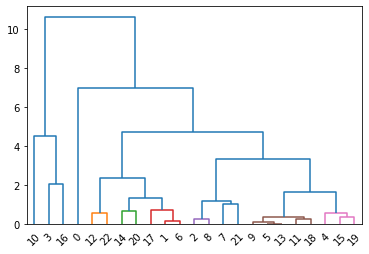

In [67]:
coord = df_poi_rank_sel.set_index('poi_id')[['lat', 'long']]
threshold = 1
data_link = linkage(coord, method='complete', metric=lambda u,v: distance.distance(u,v).km)
labels = fcluster(data_link, t=threshold, criterion='distance')
df_poi_rank_sel['label_hier'] = labels
res = dendrogram(data_link, color_threshold=threshold, truncate_mode='lastp')

In [68]:
map12 = folium.Map(location = [45.46, 9.18],zoom_start = 13, tiles='cartodbpositron', control_scale = True)  

colori = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

fg=folium.FeatureGroup(name="Poi Ratings")
for lat,lon,name,label in zip(df_poi_rank_sel['lat'],df_poi_rank_sel['long'],df_poi_rank_sel['name'],df_poi_rank_sel['label_hier']):
    fg.add_child(folium.Marker(location=[lat,lon],popup=(folium.Popup(name)),icon=folium.Icon(color=colori[label],icon_color='white')))
map12.add_child(fg)
map12

In [53]:
df_poi_rank_sel

,poi_id,name,zone,actual_n_reviews,duration_num,lat,long,category_1,category_2,rating,sim,sim_rating,interest,popularity,rank_1,rank_2,type_rank,label_hier
0,d591217,Chiesa di San Maurizio al Monastero Maggiore,Centro Storico,2229,0.75,45.465575,9.178940,Churches-Religious Sites,Art-Culture,1.848811,0.720639,1.332973,1.0,0.807515,1.494476,3.030953,12,2
1,d7390600,Museo Di Sant'Eustorgio,Ticinese,23,2.50,45.454067,9.180958,Museums,Churches-Religious Sites,1.695652,0.807145,1.375180,0.6,0.328429,1.440866,2.748483,12,3
2,d6124852,Duomo Rooftops,Centro Storico,3628,1.50,45.464098,9.191926,Architecture,History,1.731808,0.722412,1.253353,1.0,0.858539,1.425061,2.925928,12,4
3,d13229415,Torre Hadid,Zone 8,41,0.25,45.477856,9.155203,Architecture,NaN,1.682927,0.771940,1.312524,1.0,0.388980,1.390320,2.832663,12,5
4,d6686075,Fonderia Napoleonica Eugenia,Zone 9,18,2.50,45.493279,9.187848,Museums,History,1.666667,0.806420,1.325398,0.6,0.302753,1.385949,2.713638,12,6
5,d1062832,Palazzo Clerici,Centro Storico,77,1.50,45.466772,9.187100,Architecture,Museums,1.558442,0.821446,1.284140,1.0,0.454994,1.375139,2.770886,12,4
6,d1930515,Villa Necchi Campiglio,Centro Storico,1001,2.50,45.468323,9.201836,Architecture,Museums,1.669331,0.738066,1.230205,1.0,0.723661,1.374937,2.852129,12,1
7,d314197,Il Cenacolo,Centro Storico,5066,1.50,45.466307,9.170647,Art-Culture,Museums,1.701737,0.694777,1.186238,0.6,0.893511,1.364940,2.755216,12,2
8,d2160064,The Bramante Sacristy,Centro Storico,46,0.75,45.466240,9.171693,Churches-Religious Sites,Art-Culture,1.630435,0.785735,1.284277,1.0,0.401033,1.364483,2.796376,12,2
9,d1905650,Palazzo Castiglioni,Centro Storico,47,0.25,45.471128,9.201379,Architecture,Museums,1.510638,0.847672,1.276698,1.0,0.403285,1.357355,2.738968,12,1


In [69]:
map12 = folium.Map(location = [45.46, 9.18],zoom_start = 13, tiles='cartodbpositron', control_scale = True)  

colori = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

for lat, lon, name, label, num, in zip(
                                        df_poi_rank_sel['lat'],
                                        df_poi_rank_sel['long'],
                                        df_poi_rank_sel['name'],
                                        df_poi_rank_sel['label_hier'],
                                        df_poi_rank_sel['type_rank']):
    #folium.Marker(
    #    location=[lat,lon],
       #popup=(folium.Popup(name)),
    #    icon=folium.Icon(color='white',icon_color='white')
    #).add_to(map12)

    folium.Marker(
        location=[lat,lon],
        popup=(folium.Popup(name)),
        icon= number_DivIcon(colori[label], str(num))
    ).add_to(map12)
map12